In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

!pip install mitdeeplearning 
import mitdeeplearning as mdl

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity >/dev/null 2>&1

assert len(tf.config.list_physical_devices('GPU')) > 0



In [ ]:
tf.config.list_physical_devices() #ensuring that GPU turned on  

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
songs = md1.lab1.load_training_data() #thousands of irish folk songs in ABC notation

example_song = songs[0]
print('\n Sample Song')
print('\nthis is in abc notation\n')
print(example_song)
#md1.lab1.play_song(example_song)


Found 816 songs in text

 Sample Song

this is in abc notation

X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!


In [ ]:
#Joining song strings into a single string of all songs

songs_joined = "\n\n".join(songs) #join func adds all the string into a single 1
#with two spaces between each string

#finding all the unique characters in the joined string
vocab = sorted(set(songs_joined)) #filtered to only unique items
print('there are',len(vocab),'unique charachters in the dataset')

there are 83 unique charachters in the dataset


*Vectorizing text*

In [ ]:
### Defining numerical representation of text 

#Creating a mapping from character to unique index
#enumerating ex: d:4..
#char2idx['d'] can be used

char2idx = {u:i for i,u in enumerate(vocab)}

#create a mapping from indices to characters
#the inverse of char2idx can do that
#from unique index to the character

idx2char = np.array(vocab) # making a array of elements thus accessing from their indices
 


In [ ]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 '#': 4,
 "'": 5,
 '(': 6,
 ')': 7,
 ',': 8,
 '-': 9,
 '.': 10,
 '/': 11,
 '0': 12,
 '1': 13,
 '2': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '8': 20,
 '9': 21,
 ':': 22,
 '<': 23,
 '=': 24,
 '>': 25,
 'A': 26,
 'B': 27,
 'C': 28,
 'D': 29,
 'E': 30,
 'F': 31,
 'G': 32,
 'H': 33,
 'I': 34,
 'J': 35,
 'K': 36,
 'L': 37,
 'M': 38,
 'N': 39,
 'O': 40,
 'P': 41,
 'Q': 42,
 'R': 43,
 'S': 44,
 'T': 45,
 'U': 46,
 'V': 47,
 'W': 48,
 'X': 49,
 'Y': 50,
 'Z': 51,
 '[': 52,
 ']': 53,
 '^': 54,
 '_': 55,
 'a': 56,
 'b': 57,
 'c': 58,
 'd': 59,
 'e': 60,
 'f': 61,
 'g': 62,
 'h': 63,
 'i': 64,
 'j': 65,
 'k': 66,
 'l': 67,
 'm': 68,
 'n': 69,
 'o': 70,
 'p': 71,
 'q': 72,
 'r': 73,
 's': 74,
 't': 75,
 'u': 76,
 'v': 77,
 'w': 78,
 'x': 79,
 'y': 80,
 'z': 81,
 '|': 82}

In [ ]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output
vectorized_songs = vectorize_string(songs_joined)


In [ ]:
len(vectorized_songs)

200425

### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples
###hello -- hell-input ello-output

def get_batch(vectorized_songs , seq_length , batch_size):
  #length of vectorized songs
  n = vectorized_songs.shape[0] - 1 #24xxx
  #randomy choosing the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length , batch_size ) #the first param is max value , and the second is how many choices are required
  #constructing a list of input seqences
  input_batch=[vectorized_songs[i : i+seq_length] for i in idx] #taking a random initial point to i+seq length
  output_batch=[vectorized_songs[i+1 : i+seq_length+1]for i in idx]#output should contain the next unseen character as well
  #x_batch , y_batch providing the true inputs and targets for network training
  x_batch = np.reshape(input_batch ,[batch_size ,  seq_length])
  y_batch = np.reshape(output_batch , [batch_size , seq_length])#a , shape
  return x_batch , y_batch


In [ ]:
#performing tests for checking batch function working

test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")


[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [ ]:
'''For each of these vectors, each index is processed at a single time step.
 So, for the input at time step 0, the model receives the index for the first character 
 in the sequence, and tries to predict the index of the next character.
  At the next timestep, it does the same thing, but the RNN considers the
   information from the previous step, i.e., its updated state, in addition
    to the current input.

We can make this concrete by taking a look at how this 
works over the first several characters in our text:'''



x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 56 ('a')
  expected output: 62 ('g')
Step   1
  input: 62 ('g')
  expected output: 62 ('g')
Step   2
  input: 62 ('g')
  expected output: 64 ('i')
Step   3
  input: 64 ('i')
  expected output: 60 ('e')
Step   4
  input: 60 ('e')
  expected output: 0 ('\n')


In [ ]:
####Defining the RNN model
#the model will first contain Embedding_layer  This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with embedding_dim dimensions.
#2nd Lstm with units=rstm_units
#3rd dense , with vocab_size outputs


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

In [ ]:


def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [ ]:
###defining RNN model


def build_model(vocab_size , embedding_dim , rnn_units , batch_size):
  model=tf.keras.Sequential([ #embedding layer to transform indices into dense vectors of a fixed embedding size
                             tf.keras.layers.Embedding(vocab_size , embedding_dim , batch_input_shape=[batch_size,None]),
              LSTM(rnn_units),
              tf.keras.layers.Dense(vocab_size)#to convert LSTM outputinto vocab size

  ])
  return model

In [ ]:
model=build_model(len(vocab),embedding_dim=256,rnn_units=1024,batch_size=32)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (32, None, 256)           21248     
_________________________________________________________________
lstm_2 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#checking if our model can work on inputs of any length , with sequence length = 100
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


Predictions from the untrained model
Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a softmax over our character vocabulary. This will give us actual character indices. This means we are using a categorical distribution to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the argmax, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [ ]:
sampled_indices = tf.random.categorical(pred[0],num_samples=1)
sampled_indices=tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 8, 79, 15, 12, 81, 29, 49, 68, 10, 19, 56,  1, 58, 55, 74, 30, 37,
       50, 17,  0, 12, 79, 12, 45,  8, 71, 63, 53,  9, 59, 69, 10, 65, 65,
       46, 70, 60, 81, 26,  6, 72, 41,  1, 11, 42, 62,  3, 31,  4, 55, 11,
       73, 71, 71, 26, 12, 57, 41, 23, 26, 43, 43, 60,  1, 70,  3, 17, 72,
       17, 80,  5, 59, 59, 49, 16, 52,  0, 33, 75, 79, 48, 47, 59, 12, 78,
       65, 13,  6, 22, 67, 18, 51, 25, 10, 20, 17, 19, 68, 30, 33])

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '|bgdB cBAG|Fd^cd Adce|d2ed cAFA|!\nGDBG dBgd|bgdB cBAG|fedc edBG|FADF G2:|!\nga|bgdB GBdg|afcA FAcf|af'

Next Char Predictions: 
 ',x30zDXm.7a c_sELY5\n0x0T,ph]-dn.jjUoezA(qP /Qg"F#_/rppA0bP<ARRe o"5q5y\'ddX4[\nHtxWVd0wj1(:l6Z>.857mEH'


In [ ]:
### Defining the loss function ###


   
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
 
  return loss

'''computing the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)


print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4185724


In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

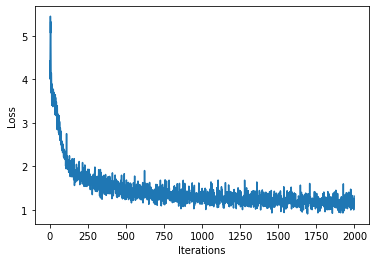

100%|██████████| 2000/2000 [03:20<00:00,  9.99it/s]


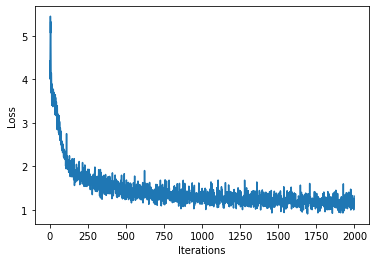

In [ ]:
### Define optimizer and training operation ###

'''instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# model = build_model('''TODO: arguments''')

'''instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = # TODO

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''feed the current input into the model and generate predictions'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')
  
    '''compute the loss!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')

  # Now, compute the gradients 
  '''completing the function call for gradient computation. 
     we want the gradient of the loss with respect all 
      of the model parameters. 
      use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
# model = build_model('''TODO''', '''TODO''', '''TODO''', batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (16, None, 256)           21248     
_________________________________________________________________
lstm_4 (LSTM)                (16, None, 1024)          5246976   
_________________________________________________________________
dense_4 (Dense)              (16, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string] # TODO
  # input_eval = ['''TODO''']
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # predictions = model('''TODO''')
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (start_string + ''.join(text_generated))

In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

In [ ]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Found 2 songs in text
Generated song 0


Generated song 1
